In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2



from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import pandas as pd

In [2]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [3]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]) )

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def get_y(bbox,clas):
    # accept 1 input at a time
    bbox = bbox.view(-1,4)/sz #scale down to [0,1] relative to 224 (size of img)
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0] # index of non-zero entry
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    '''
    Convert conv2d bbox output for 1 img (16,4 coords upper left lower right) 
    to a (16,4 coord lower left upper right) matrix based on anchor box h,w and center
    
    actn: (16,4) y1x1 y2x2
    anchors: (16,4) center_x,center_y,w,h (w=h=grid_sizes)
    '''
    actn_bbs = torch.tanh(actn) # scale b/t -1 and 1
    
    # move center of anchor box around actn/2
    # each preditive bbox can be mobed by up to 50% of a grid size
    # where its default position (anchor box) is
    # TODO: ???
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

In [4]:
class ConcatLblDataset(Dataset): 
    # create new dataset with original X and new y which is a tuple: (y_bbox,y_label)
    # inherit torch Dataset
    
    def __init__(self, ds, y2): 
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    #self.ds contains np array X and y of bbox dataset
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i])) # (X,(y_bbox,y_label))

# Prepare data

In [5]:
PATH = Path('data/pascal')
# list(PATH.iterdir())

JPEGS = 'VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

all_df = pd.read_csv(PATH / 'all_info.csv')
mult_cat= pd.read_csv(PATH / 'mult_cat.csv')
mult_bbox= pd.read_csv(PATH / 'mult_bbox.csv') 

cats=all_df[['category_id','cat_name']].drop_duplicates().values

id2cat = {i[0]-1:i[1] for i in cats}
cat2id = {i[1]:i[0]-1 for i in cats}

mcs=np.array([np.array([cat2id[j] for j in i.split(' ')]) for i in mult_cat.cat_name.values ])
# mcs

val_idxs = get_cv_idxs(mult_bbox.shape[0])
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

In [6]:
f_model=resnet34
sz=224
bs=16

MBB_CSV = PATH / 'mult_bbox.csv'
aug_tfms = [RandomRotate(10, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4)

In [7]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

# Plot image + bounding box + label for 1 image

In [8]:
im_path = IMG_PATH / mult_bbox.loc[0,'file_name']

In [9]:
def open_image(im_path):
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    im = cv2.imread(str(im_path), flags).astype(np.float32)/255 # normalize
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [10]:
im = open_image(im_path)

In [11]:
im.shape

(333, 500, 3)

In [12]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
#     ax.set_xticks(np.linspace(0, 224, 8))
#     ax.set_yticks(np.linspace(0, 224, 8))
#     ax.grid()
#     ax.set_yticklabels([])
#     ax.set_xticklabels([])
    return ax

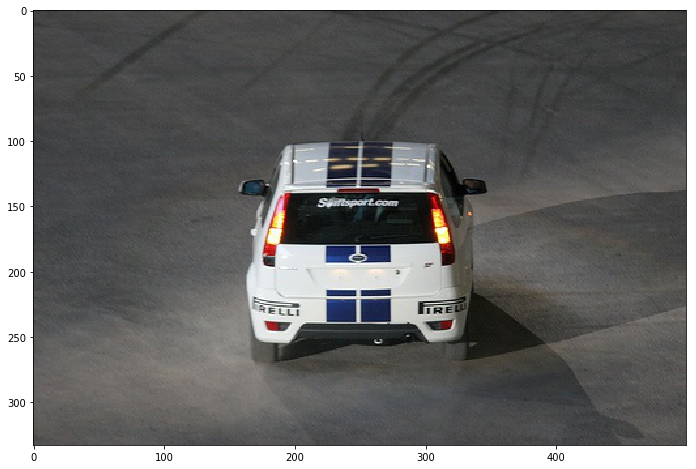

In [13]:
ax = show_img(im,figsize=(16,8))

In [14]:
bbox = mult_bbox.loc[0,'bbox']
y1,x1,y2,x2= map(int,bbox.split(' '))

In [15]:
def bb_wh(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]]) # x1,y1,width and height
wh = bb_wh([y1,x1,y2,x2])

In [16]:
wh

array([155,  96, 195, 173])

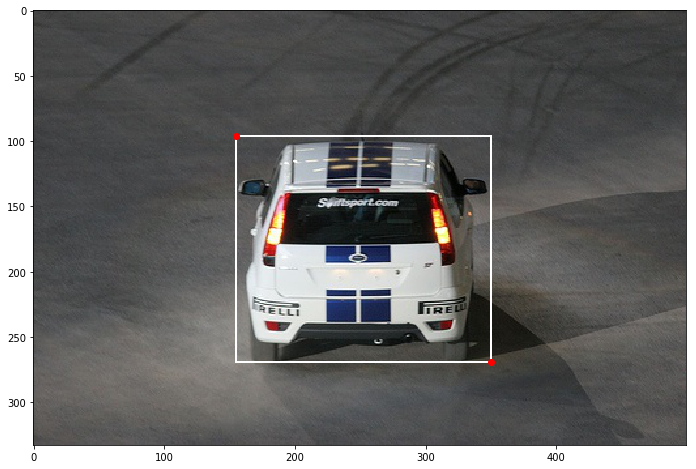

In [17]:
ax = show_img(im,figsize=(16,8))
plt.plot(x1, y1,'ro')
plt.plot(x2, y2,'ro')
#draw_rect
patch = ax.add_patch(patches.Rectangle(wh[:2],*wh[-2:],fill=False,edgecolor='white',lw=2)) #lw is linewidth

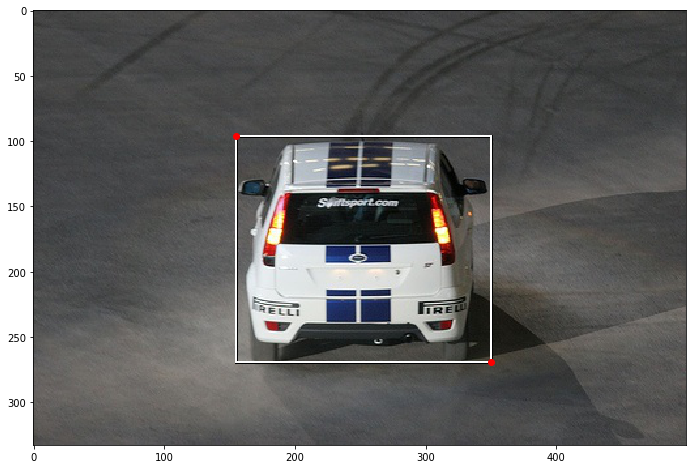

In [18]:
ax = show_img(im,figsize=(16,8))
plt.plot(x1, y1,'ro')
plt.plot(x2, y2,'ro')
#draw_rect
rec_patch = ax.add_patch(patches.Rectangle(wh[:2],*wh[-2:],fill=False,edgecolor='white',lw=2)) #lw is linewidth
#draw_outline: draw black border (inside and outside) to rectangle with patheffects.Stroke
lw=3
rec_patch.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

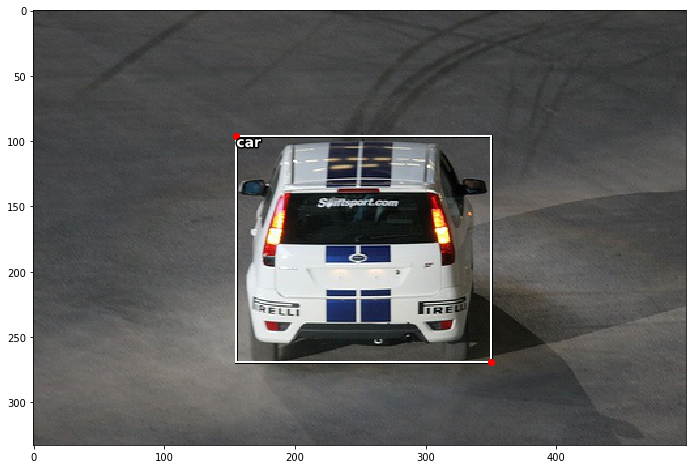

In [19]:
ax = show_img(im,figsize=(16,8))
plt.plot(x1, y1,'ro')
plt.plot(x2, y2,'ro')
#draw_rect
patch = ax.add_patch(patches.Rectangle(wh[:2],*wh[-2:],fill=False,edgecolor='white',lw=2)) #lw is linewidth
#draw_outline: draw black border (inside and outside) to rectangle with patheffects.Stroke
lw=3
patch.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])


#draw_text
text = ax.text(*wh[:2], 'car',
        verticalalignment='top', color='white', fontsize=14, weight='bold')
# draw black border to text
lw=3
text.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

# Previous parts but with multiple images

In [20]:
# Put all plotting steps above to into functions
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
#     ax.set_xticks(np.linspace(0, 224, 8))
#     ax.set_yticks(np.linspace(0, 224, 8))
#     ax.grid()
#     ax.set_yticklabels([])
#     ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 3)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 2)
def bb_wh(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])



In [21]:
# get 12 colors, each with R-G-B-A values
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba
# 
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [22]:
colr_list

[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451, 1.0),
 (1.0, 1.0, 0.7019607843137254, 1.0),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137, 1.0),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118, 1.0),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568, 1.0),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961, 1.0),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529, 1.0),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745, 1.0),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627, 1.0),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353, 1.0),
 (0.8, 0.9215686274509803, 0.7725490196078432, 1.0),
 (1.0, 0.9294117647058824, 0.43529411764705883, 1.0)]

In [23]:
X,y=to_np(next(iter(md.val_dl)))

In [24]:
X = md.trn_ds.ds.denorm(X)

In [25]:
print(y[1][0])
[bb_wh(o) for o in y[0][0].reshape(-1,4)]

[ 0  0  0  0  0  0  0  0  0  0  0  1 14 14]


[array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([ 47.,  91., 122., 132.], dtype=float32),
 array([ 49.,   0., 131., 205.], dtype=float32),
 array([169.,   9.,  53., 208.], dtype=float32)]

In [26]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_wh(o) for o in bbox.reshape(-1,4)]
    
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
        
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        # draw only when bbox's width >0 and pr > thres
        if((b[2]>0) and (pr is None or pr > thresh)): 
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            # txt contains: index (can be ignored) + class + probability (from activations)
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


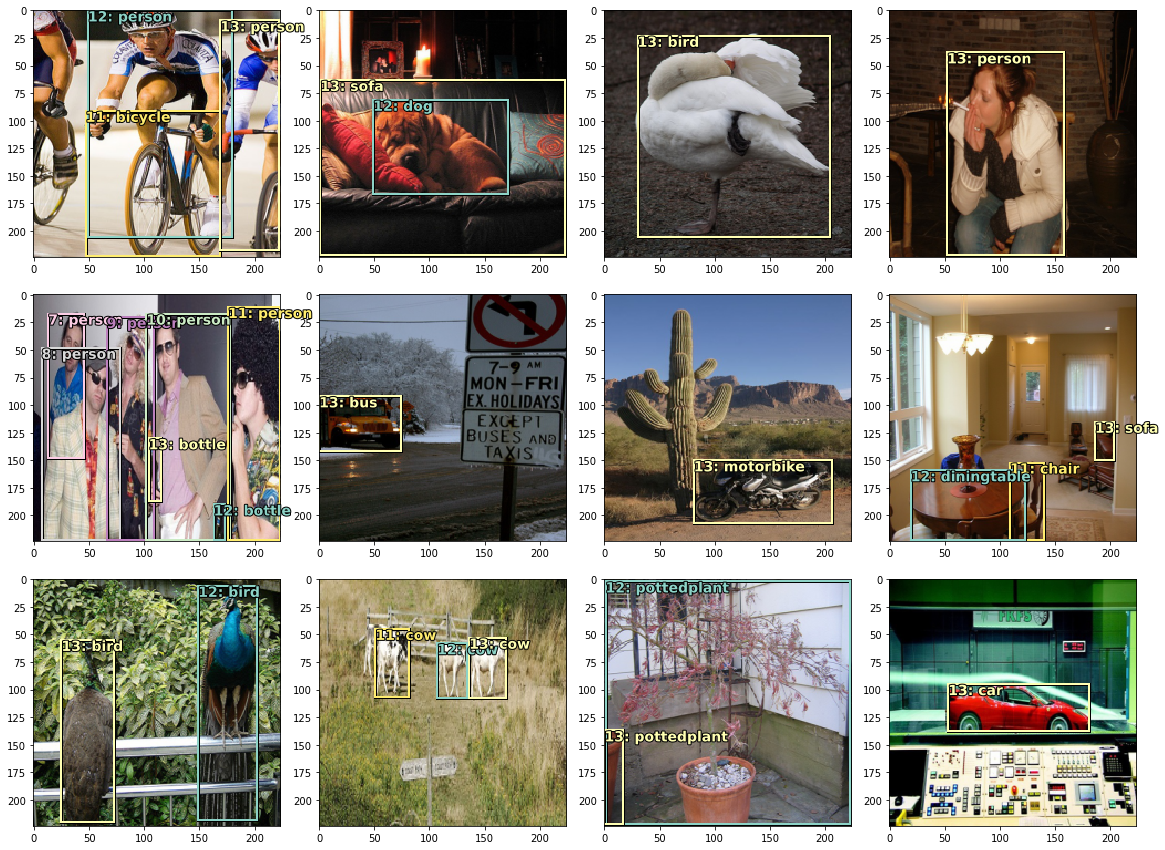

In [27]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, X[i], y[0][i], y[1][i])
plt.tight_layout()

# Anchor boxes

Goals:
- Produce anchor_cnr: (upper left, bottom right) to calculate jaccard overlaps between bbox.data and anchor_cnr.data
- Produce anchors (x_center,y_center,w,h): to do an anchor-box transformation on model's activation (through actn_to_bb) -> produce a_ic

Note: both of these are scaled down to [0,1] and have torch.FloatTensor type

## 4x4 anchor box

In [28]:
anc_grid = 4 # 4x4 = 16 anchor boxes
k = 1

In [29]:
anc_offset = 1/(anc_grid*2) # offset b/t abox corner and its center

In [31]:
anc_offset

0.125

In [33]:
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

In [36]:
print(anc_x)
print(anc_y)

[0.125 0.125 0.125 0.125 0.375 0.375 0.375 0.375 0.625 0.625 0.625 0.625 0.875 0.875 0.875 0.875]
[0.125 0.375 0.625 0.875 0.125 0.375 0.625 0.875 0.125 0.375 0.625 0.875 0.125 0.375 0.625 0.875]


In [44]:
np.stack([anc_x,anc_y], axis=1).shape

(16, 2)

In [54]:
anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (1,1))
anc_ctrs.shape

(16, 2)

In [59]:
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anc_sizes

array([[0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25],
       [0.25, 0.25]])

In [60]:
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

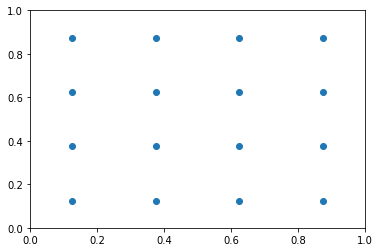

In [64]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [65]:
def hw2corners(ctr, hw): 
    return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.FloatTensor of size 16x4]

In [68]:
anchor_cnr.size()

torch.Size([16, 4])

In [69]:
abox = to_np(anchor_cnr.data)*224

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


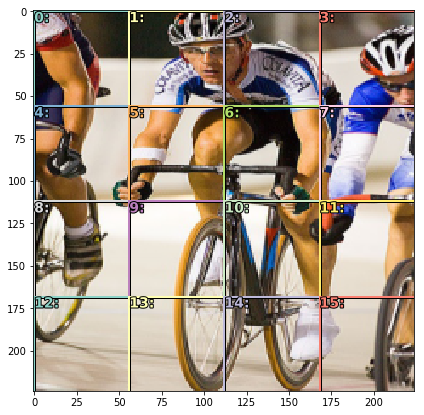

In [70]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, X[0], abox)

# IOU calculation (Jaccard)

In [88]:
idx=7

In [89]:
bbox_abox = np.concatenate([y[0][idx].reshape(-1,4),abox],axis=0)

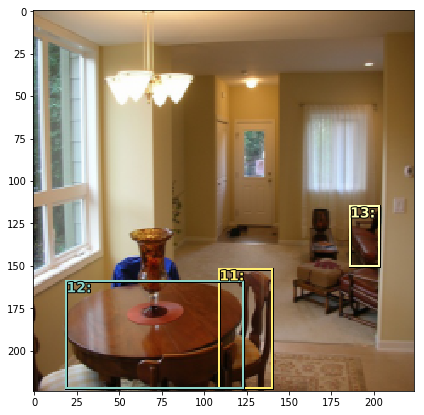

In [90]:
ig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, X[idx], y[0][idx].reshape(-1,4))

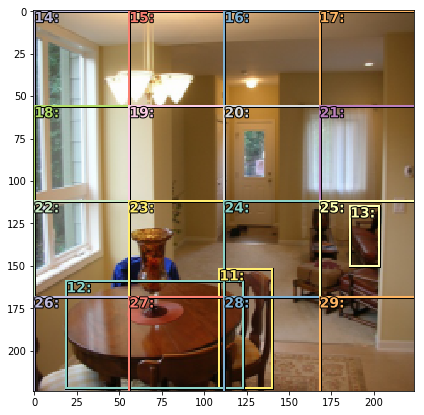

In [91]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, X[idx], bbox_abox)